In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
fb_land = pd.read_csv('./ReducedData/fb_land.csv')[['gameId','playId','hangTime','frameId']]

data = pd.read_csv('./ReducedData/BC_AllPlayers.csv')
bounce_nf = ['Downed','Out of Bounds','Touchback']
data['Label'] = data['Type'].map({'Bounce':'No Field','Catch':'Field'})
data.loc[(data['Type']=='Bounce')&(~data['specialTeamsResult'].isin(bounce_nf)),'Label'] = 'Field'

returnable_plays = data[(data['Label']=='Field')&(~data['specialTeamsResult'].isin(['Muffed','Downed','Fair Catch']))]
display(returnable_plays)

landframe = returnable_plays[['gameId','playId']].merge(pd.read_csv('./ReducedData/fb_land.csv')[['gameId','playId','frameId']])
landframe.rename({'frameId':'landFrame'},axis=1,inplace=True)

,gameId,playId,nflId_punt,x_punt,y_punt,x_p0,y_p0,x_p1,y_p1,x_p2,...,x_r10,y_r10,x_fb,y_fb,x_land,y_land,hangTime,Type,specialTeamsResult,Label
0,2018090600,366,45603.0,4.20,31.01,13.76,31.14,16.39,27.64,16.76,...,18.41,33.63,18,29.94,72.61,39.18,4.46,Catch,Return,Field
4,2018090600,1989,37267.0,22.04,23.28,35.09,6.01,32.44,21.67,30.72,...,36.87,7.23,36,23.79,92.21,35.84,4.62,Catch,Return,Field
6,2018090600,2599,37267.0,22.03,26.11,35.30,6.27,33.02,24.38,31.38,...,36.94,7.49,36,26.47,81.65,41.60,4.16,Catch,Return,Field
10,2018090600,3868,37267.0,25.04,30.39,37.85,5.97,35.34,27.63,33.83,...,39.82,6.42,39,29.52,89.12,21.27,4.40,Catch,Return,Field
11,2018090900,485,46903.0,23.89,23.81,36.14,24.29,36.36,20.93,37.18,...,37.90,26.31,38,23.46,82.80,9.40,4.34,Catch,Return,Field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5508,2021010315,928,47893.0,23.16,24.96,33.32,21.12,32.17,22.40,36.54,...,38.35,28.75,38,23.79,86.06,41.50,4.43,Catch,Return,Field
5509,2021010315,1359,47893.0,15.40,30.93,26.04,26.90,29.06,44.17,24.93,...,30.45,34.22,30,29.57,74.63,50.46,4.50,Catch,Return,Field
5510,2021010315,1479,46218.0,17.94,27.95,31.31,25.71,29.25,29.00,32.20,...,34.10,45.28,33,26.69,92.58,11.68,4.80,Catch,Return,Field
5511,2021010315,2235,46218.0,22.08,24.90,35.07,22.98,32.97,26.20,35.80,...,37.55,44.65,37,23.84,78.69,27.04,3.36,Catch,Return,Field


In [3]:
# 2018 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2018.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_18 = football_tracking.merge(landframe)
punt_fbtrack_18['time'] = pd.to_datetime(punt_fbtrack_18['time'])

# 2019 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2019.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_19 = football_tracking.merge(landframe)
punt_fbtrack_19['time'] = pd.to_datetime(punt_fbtrack_19['time'])

# 2020 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2020.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_20 = football_tracking.merge(landframe)
punt_fbtrack_20['time'] = pd.to_datetime(punt_fbtrack_20['time'])

punt_fbtrack = pd.concat([punt_fbtrack_18,punt_fbtrack_19,punt_fbtrack_20]) \
                .sort_values(by=['gameId','playId','frameId']) \
                .drop(columns=['o','dir','nflId','displayName','jerseyNumber','position','team']) \
                .reset_index(drop=True)

after_land = punt_fbtrack[punt_fbtrack['frameId']>=punt_fbtrack['landFrame']]

In [15]:
frames_wevent = after_land[after_land['event']!='None'].copy()
excl_events=['punt_received','punt_land','kick_received','fair_catch','penalty_flag','lateral','pass_outcome_caught']
frames_wevent = frames_wevent[~frames_wevent['event'].isin(excl_events)]

no_events = after_land.merge(frames_wevent[['gameId','playId']].drop_duplicates(), how='left', indicator=True).query('_merge=="left_only"').drop(columns=['_merge'])

In [16]:
frames_wevent['count'] = frames_wevent.groupby(['gameId','playId']).cumcount()
event_table = pd.pivot_table(frames_wevent, index=['gameId','playId'], columns='count',values='event',aggfunc=lambda x: ''.join(x))

event_table

count                          0       1    2    3    4    5
gameId     playId                                           
2018090600 366     first_contact  tackle  NaN  NaN  NaN  NaN
           1989    first_contact  tackle  NaN  NaN  NaN  NaN
           2599    first_contact  tackle  NaN  NaN  NaN  NaN
           3868    first_contact  tackle  NaN  NaN  NaN  NaN
2018090900 485     first_contact  tackle  NaN  NaN  NaN  NaN
...                          ...     ...  ...  ...  ...  ...
2021010315 928     first_contact  tackle  NaN  NaN  NaN  NaN
           1359    first_contact  tackle  NaN  NaN  NaN  NaN
           1479    first_contact  tackle  NaN  NaN  NaN  NaN
           2235    first_contact  tackle  NaN  NaN  NaN  NaN
           2497    first_contact  tackle  NaN  NaN  NaN  NaN

[2294 rows x 6 columns]

In [17]:
questionable_events = ['touchback','punt_downed']
event_table[event_table[0].isin(questionable_events)]
# Touchback is penalty > muff, so this event will be removed
# Downed is no gain

,count,0,1,2,3,4,5
gameId,playId,,,,,,
2020092002,2683,touchback,NaN,NaN,NaN,NaN,NaN
2020102507,997,punt_downed,NaN,NaN,NaN,NaN,NaN


In [18]:
stop_at_0 = ['tackle','out_of_bounds','touchdown','first_contact','fumble', 'punt_muffed']
# The two fumble recovery events are:
# 2018 game > go to first contact
# 2019 game > go to recover

event_table[event_table[0]=='first_contact'][1].value_counts(dropna=False)

tackle                      1496
out_of_bounds                304
fumble                        20
touchdown                     16
NaN                            7
fumble_defense_recovered       2
fumble_offense_recovered       1
Name: 1, dtype: int64

In [24]:
return_values = frames_wevent.loc[(frames_wevent['count']==0)&(frames_wevent['event']!='touchback'),['gameId','playId','frameId','x','y','event']].copy()

return_values.loc[return_values['event']=='fumble_defense_recovered',['frameId','x','y']] = \
        frames_wevent.merge(frames_wevent[(frames_wevent['event']=='fumble_defense_recovered')
                                          &(frames_wevent['count']==0)][['gameId','playId']]).query('event=="first_contact"')[['frameId','x','y']].values

In [25]:
no_event_res = no_events[(no_events['y']>0)&(no_events['y']<160/3)].groupby(['gameId','playId']).last().reset_index()[['gameId','playId','frameId','x','y','event','playDirection']]
return_data = pd.concat([return_values.merge(after_land[['gameId','playId','playDirection']].drop_duplicates()),no_event_res],axis=0).reset_index(drop=True).sort_values(['gameId','playId'])
return_data.loc[return_data['playDirection']=='left','x'] = 120-return_data.loc[return_data['playDirection']=='left','x']
return_data.loc[return_data['playDirection']=='left','y'] = (160/3-return_data.loc[return_data['playDirection']=='left','y']).round(2)
return_data

,gameId,playId,frameId,x,y,event,playDirection
0,2018090600,366,100.0,67.46,40.13,first_contact,right
1,2018090600,1989,111.0,86.56,37.91,first_contact,right
2,2018090600,2599,107.0,75.05,32.01,first_contact,right
3,2018090600,3868,87.0,90.99,19.54,first_contact,left
4,2018090900,485,94.0,85.10,9.00,first_contact,left
...,...,...,...,...,...,...,...
2288,2021010315,928,98.0,81.62,39.81,first_contact,right
2289,2021010315,1359,94.0,66.90,51.40,first_contact,left
2290,2021010315,1479,86.0,94.51,12.43,first_contact,right
2291,2021010315,2235,106.0,61.95,51.04,first_contact,right


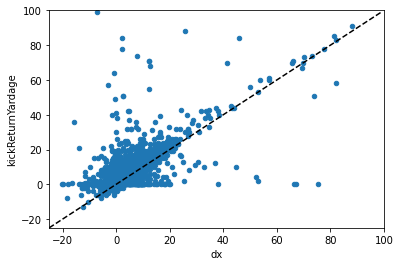

In [26]:
ret_dist = return_data.merge(returnable_plays[['gameId','playId','x_land','y_land']])
ret_dist['dx'] = ret_dist['x_land'] - ret_dist['x']
ret_dist = ret_dist.merge(pd.read_csv('./data/plays.csv')[['gameId','playId','kickReturnYardage','returnerId']])

ret_dist.plot.scatter(x='dx',y='kickReturnYardage')
plt.plot(np.arange(-25,100,1),np.arange(-25,100,1),'k--')
plt.xlim(-25,100)
plt.ylim(-25,100)
plt.show()

In [27]:
ret_dist = ret_dist.merge(fb_land, on=['gameId','playId'], suffixes=['','_land'])
ret_dist = ret_dist[['gameId','playId','playDirection','x','y','frameId','x_land','y_land','frameId_land','hangTime','kickReturnYardage']]
ret_dist['dx'] = ret_dist['x_land'] - ret_dist['x']

train_data = data.iloc[:,:-3].merge(ret_dist[['gameId','playId','dx']])

In [32]:
train_data.to_csv('./ReducedData/ReturnTrainingData/FullTeamReturn.csv', index=False)

### Return past first contact

In [28]:
post_fc = frames_wevent.merge(frames_wevent[(frames_wevent['event']=='first_contact')&(frames_wevent['count']==0)][['gameId','playId']].drop_duplicates()).query('count==1')[['gameId','playId','frameId','x','y','playDirection']]
check_post_fc = ret_dist.merge(post_fc,on=['gameId','playId','playDirection'], suffixes=['_fc','_next'])
check_post_fc.loc[check_post_fc['playDirection']=='left','x_next'] = 120-check_post_fc.loc[check_post_fc['playDirection']=='left','x_next']
check_post_fc.loc[check_post_fc['playDirection']=='left','y_next'] = (160/3-check_post_fc.loc[check_post_fc['playDirection']=='left','y_next']).round(2)
check_post_fc['dx'] = check_post_fc['x_land'] - check_post_fc['x_next']
check_post_fc

,gameId,playId,playDirection,x_fc,y_fc,frameId_fc,x_land,y_land,frameId_land,hangTime,kickReturnYardage,dx,frameId_next,x_next,y_next
0,2018090600,366,right,67.46,40.13,100.0,72.61,39.18,78,4.46,5.0,3.55,119,69.06,49.44
1,2018090600,1989,right,86.56,37.91,111.0,92.21,35.84,81,4.62,8.0,6.74,117,85.47,37.96
2,2018090600,2599,right,75.05,32.01,107.0,81.65,41.60,76,4.16,9.0,8.34,112,73.31,31.42
3,2018090600,3868,left,90.99,19.54,87.0,89.12,21.27,78,4.40,12.0,9.12,127,80.00,33.41
4,2018090900,485,left,85.10,9.00,94.0,82.80,9.40,76,4.34,-1.0,-1.50,131,84.30,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,2021010315,928,right,81.62,39.81,98.0,86.06,41.50,77,4.43,7.0,6.20,106,79.86,41.85
1835,2021010315,1359,left,66.90,51.40,94.0,74.63,50.46,77,4.50,7.0,7.56,102,67.07,52.48
1836,2021010315,1479,right,94.51,12.43,86.0,92.58,11.68,81,4.80,5.0,2.76,117,89.82,3.60
1837,2021010315,2235,right,61.95,51.04,106.0,78.69,27.04,67,3.36,21.0,19.01,113,59.68,52.51


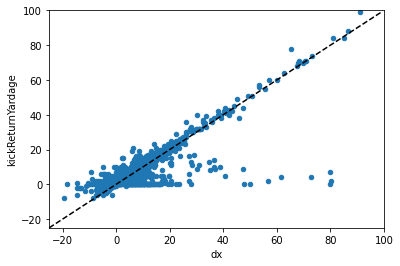

In [29]:
check_post_fc.plot.scatter(x='dx',y='kickReturnYardage')
plt.plot(np.arange(-25,100,1),np.arange(-25,100,1),'k--')
plt.xlim(-25,100)
plt.ylim(-25,100)
plt.show()